#Stage 2 Analysis

In [19]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab import drive
from scipy import stats

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [3]:
# initial dataset
INPUT_MAESTRO_DATA = "/content/drive/Shareddrives/CSE 291/Data/MAESTRO-d6178bdd-identified_variants_merged_protein_regions-main.tsv"
variants = pd.read_csv(INPUT_MAESTRO_DATA, sep="\t", low_memory=False)
# data - only dropped - 22994 features
X_drop_path = "/content/drive/Shareddrives/CSE 291/Results/X_drop.csv"
X_drop = pd.read_csv(X_drop_path)
X_drop.rename(columns ={'Unnamed: 0' : 'Patient'}, inplace = True)
# data - only dropped + imputed - 22994 features
X_KNN_path = "/content/drive/Shareddrives/CSE 291/Results/X_KNN.csv"
X_KNN = pd.read_csv(X_KNN_path).drop('Unnamed: 0', axis = 1)
# data - only dropped + imputed + feature selected - 1199 features
data_path = "/content/drive/Shareddrives/CSE 291/Results/final_dataset.csv"
data = pd.read_csv(data_path)
#rename important data
x = data.drop(['Condition','Unnamed: 0'],axis=1)
y = data['Condition']
X_drop['Condition'] = y
cond = list(y.unique())
# peptide information
peptide_info_path = "/content/drive/Shareddrives/CSE 291/Results/variants_info.csv"
peptide_info = pd.read_csv(peptide_info_path).drop('Unnamed: 0', axis = 1)

In [4]:
y.value_counts()
cond

['Healthy',
 'Non-severe-COVID-19',
 'Severe-COVID-19',
 'Symptomatic-non-COVID-19']

## Assessment on important features for the classification

In [5]:
#how many features to display
num_to_calc_fpr = 50
num_to_calc_lr = 50

num_to_disp_fpr = 50
num_to_disp_lr = 50

### Show a list of top features selected by your feature importance methods or from classification model(s)

#### Univariate Feature Importance

In [6]:
#redo feature selection to find most significant features
from sklearn.feature_selection import SelectFpr, f_classif
#define selector and get scores from it
selector = SelectFpr(f_classif, alpha = 0.05)
x_fpr = selector.fit_transform(X_KNN,y)
#get scores and then normalize
scores = -np.log(selector.pvalues_)
scores /= scores.max()
#get associations of scores and features
feature_scores = sorted(zip(scores,list(X_KNN.columns)), reverse = True)
feature_scores = feature_scores[:num_to_calc_fpr]
fpr_scores, fpr_features = list(zip(*feature_scores))
fpr_features = list(fpr_features)

#### Feature Importance Using Logistic Regression

In [7]:
#import logistic regression and relevant things
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.feature_selection import SelectFromModel
# get the top features of the logistic regression using SelectFromModel
x_scaled = scale(x)
lr = LogisticRegression(random_state = 0, multi_class = 'multinomial', penalty = 'l2', solver = 'sag',max_iter = 1000).fit(x_scaled, y)
lr_sfm = SelectFromModel(estimator = lr, prefit = True, max_features = num_to_disp_lr)
lr_sfm_features = [i for indx, i in enumerate(x.columns) if lr_sfm.get_support()[indx] == True]
# get feature importance scores by getting the sum of magnitudes of coefficients
lr_feat_imp = np.sum(abs(lr.coef_), axis = 0)
lr_feat_scores = sorted(zip(lr_feat_imp,list(x.columns)), reverse = True)
lr_feat_scores = lr_feat_scores[:num_to_calc_lr]
lr_scores, lr_features = list(zip(*lr_feat_scores))
lr_features = list(lr_features)
# cross-check with results from SelectFromModel - verified by getting same 
# 30 using both methods

In [8]:
#get intersection of important peptides from both methods

common_features = list(set(fpr_features)&set(lr_features))
commonTemp = []

for i in common_features: 
  avgIdx = (fpr_features.index(i) + lr_features.index(i))/2
  commonTemp.append((i, avgIdx))
commonTemp = sorted(commonTemp, key= lambda x: x[1])

common_features = [i[0] for i in commonTemp]
print(len(common_features), common_features)

# Get the Top N features
N = 10
print("TOP ", N, " FEATURES: ", common_features[:N])

13 ['K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P', 'K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T', 'R.{291.173}[304.207]ILGGHLDA(K,304.207).G', 'K.[304.207](C,57.021)(C,57.021)AAADPHE.C', 'K.[304.207](K,304.207)QTALVELV(K,520.821)H(K,304.207).P', 'K.[304.207](V,290.171)DNALQSGNSQESVTEQDS(K,304.207).D', 'R.{290.173}[304.207]EGT(C,57.021)PEAPTDE(C,57.021)(K,304.207)PV(K,304.207).W', 'K.[304.207](Y,116.074)LYETTLE(K,304.207).C', 'K.[304.207](P,238.418)(K,304.207)DTLMISR.T', 'K.[304.207](Q,291.175)N(C,57.021)ELFEQLGEY(K,304.207).F', 'K.[304.207]L(K,331.18)E(C,57.021)(C,57.021)E(K,304.207)PLLE(K,304.207).S', 'K.{311.984}[304.207]YI(C,57.021)ENQDSI.S', 'R.[304.207]HYEG(S,-18.005)TVPE(K,304.207)(K,304.207).T']
TOP  10  FEATURES:  ['K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P', 'K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T', 'R.{291.173}[304.207]ILGGHLDA(K,304.207).G', 'K.[304.207](C,57.021)(C,57.021)AAADPHE.C', 'K.[304.207](K,304.207)QTALVELV(K,520.821)H(K,304.207).P

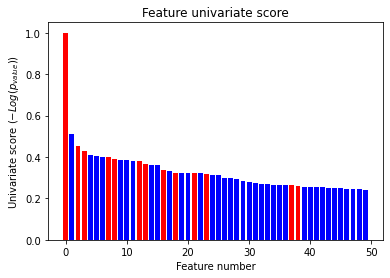

50 ['K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T', 'K.[304.207](S,144.078)LHTLFGD(K,304.207).L', 'R.{291.173}[304.207]ILGGHLDA(K,304.207).G', 'K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P', 'D.[304.207](K,203.075)SLHTLFGD(K,304.207).L', 'R.[304.207](Q,-48.618)(K,304.207)LHELQE(K,304.207).L', 'F.[304.207](K,291.14)DLGEENF(K,304.207).A', 'R.{290.173}[304.207]EGT(C,57.021)PEAPTDE(C,57.021)(K,304.207)PV(K,304.207).W', 'K.[304.207](P,238.418)(K,304.207)DTLMISR.T', 'R.[304.207]F(K,244.129)DLGEENF(K,304.207).A', 'K.[304.207](S,143.085)LHTLFGD(K,304.207).L', 'S.[304.207]IGYADSV(K,304.207).G', 'K.[304.207](Y,116.074)LYETTLE(K,304.207).C', 'K.[304.207](V,290.171)DNALQSGNSQESVTEQDS(K,304.207).D', 'K.[304.207]T(K,304.207)GTFAHR.D', 'R.[304.207]SYS(C,57.021)QVTH(E,11.673)GSTVE(K,304.207).T', 'K.[304.207]L(K,331.18)E(C,57.021)(C,57.021)E(K,304.207)PLLE(K,304.207).S', 'R.[304.207]ESLLN(H,57.028)FLYEVAR.R', 'K.[304.207](Q,291.175)N(C,57.021)ELFEQLGEY(K,304.207).F', 'K.[304.207](T,-13.036)

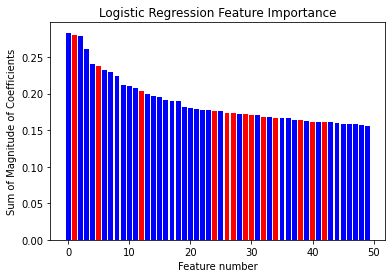

50 ['K.[304.207]AEFAEV(S,31.006)(K,304.207).L', 'K.[304.207](K,304.207)QTALVELV(K,520.821)H(K,304.207).P', 'C.[304.207]EVQLVES(G,42.052)GGLV(K,304.207)PGGSLR.L', 'K.[304.207](C,85.056)(C,57.021)TESLVNR.R', 'K.[304.207]QN(C,57.021)ELFEQ(L,30.007)GEY(K,304.207).F', 'K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P', 'K.[304.207]YAATSQVLL(P,336.082)S(K,304.207).D', 'V.[304.207](E,-61.082)EYAN(C,57.021)HLAR.A', 'R.[304.207]HNVYINGITYT(P,100.028)VSSTNE(K,304.207).D', 'K.[304.207](K,628.32)QTALVELV(K,304.207).H', 'K.[304.207]LVD(K,304.207)FLED(V,272.169)(K,304.207).K', 'K.[304.207]RGPGGAWAAEV(I,290.196)TDAR.E', 'K.[304.207](C,57.021)(C,57.021)AAADPHE.C', 'K.[304.207]AEFAEV(S,-10.635)(K,304.207).L', '-.[304.207]DIQ(M,68.912)TQSPSSLSASVGDR.V', 'K.[304.207]N(K,304.207)YEDEIN(K,304.207)R.T', 'R.[304.207]TLLETLQ(K,304.207).A', 'K.[304.207]AEF(A,28.036)EVS(K,304.207).L', 'D.[304.207](M,-56.112)AEIE(K,304.207)FD(K,304.207).S', 'K.[304.207]VLGAF(S,304.213)DGLAHLDNL(K,304.207).G', 'K.[304.207]L

In [9]:
#plot bar plots of the feature importance score for both methods
#peptide variants common to both methods have a different color than those only in one method
color_dict = {0: 'red', 1: 'blue'}
fpr_color_list = []
for i in fpr_features[:num_to_disp_fpr]:
  if i in common_features:
    fpr_color_list.append(color_dict[0])
  else:
    fpr_color_list.append(color_dict[1])

lr_color_list = []
for i in lr_features[:num_to_disp_lr]:
  if i in common_features:
    lr_color_list.append(color_dict[0])
  else:
    lr_color_list.append(color_dict[1])

plt.figure()
plt.title("Feature univariate score")
plt.bar(range(0,num_to_disp_fpr),fpr_scores[:num_to_disp_fpr],color=fpr_color_list)
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()
print(len(fpr_features), fpr_features)
plt.figure()
plt.title("Logistic Regression Feature Importance")
plt.bar(range(0,num_to_disp_lr),lr_scores[:num_to_disp_lr],color=lr_color_list)
plt.xlabel("Feature number")
plt.ylabel("Sum of Magnitude of Coefficients")
plt.show()
print(len(lr_features), lr_features)

### Evaluate how well each important feature (or groups of features) correlate to the classes

Covered in next section

### Show supporting evidence supporting your evaluation of the quality of the selected important features

In [10]:
def z_score(df,max_score):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std[column] = df_std[column].map(lambda x: x if np.isnan(x) else min(max_score,max(-max_score,x)))
    return df_std

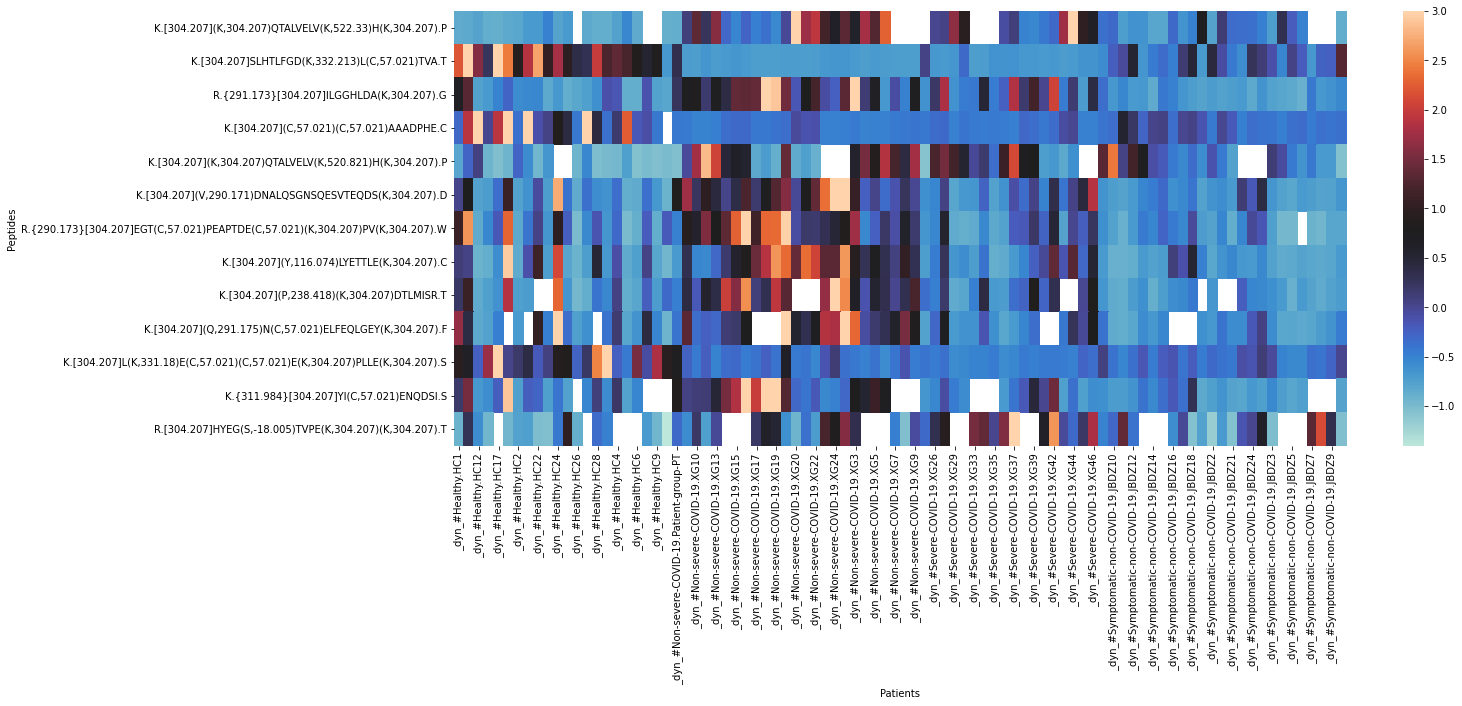

In [11]:
# heatmap of common features
X_drop_copy = X_drop.copy()
X_drop_copy.set_index('Patient',inplace=True)
X_drop_common = X_drop_copy.loc[:,list(common_features)]
X_drop_common_hm = z_score(X_drop_common,3)
X_drop_common_hm = X_drop_common_hm.T

plt.figure(figsize=(20,8))
cmap = sns.color_palette("icefire", as_cmap=True)
sns.heatmap(X_drop_common_hm, cmap=cmap)
plt.xlabel('Patients')
plt.ylabel('Peptides')
plt.show()

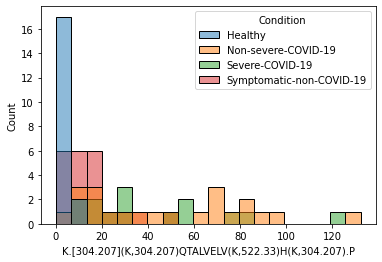

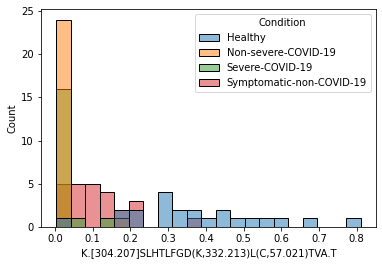

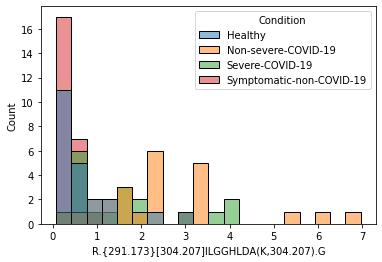

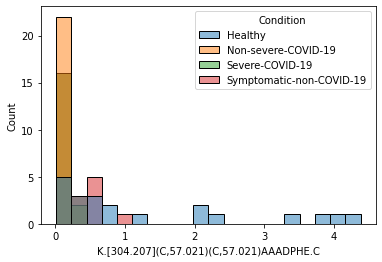

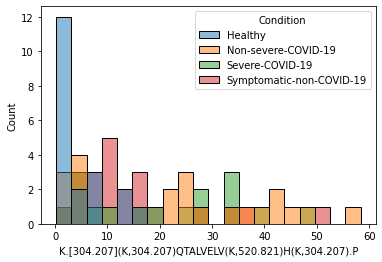

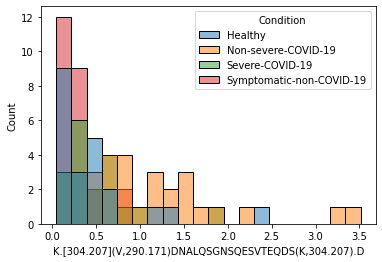

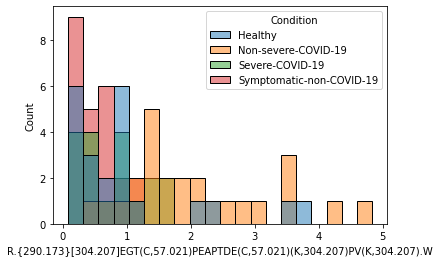

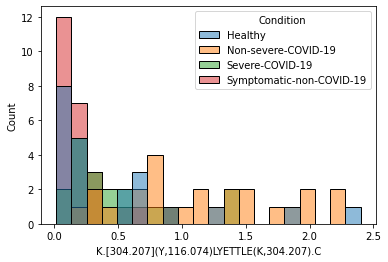

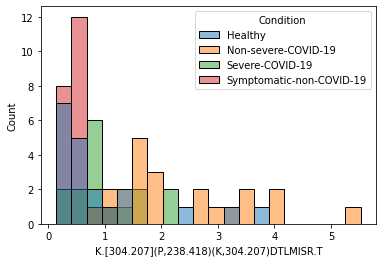

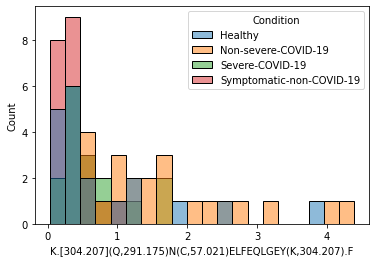

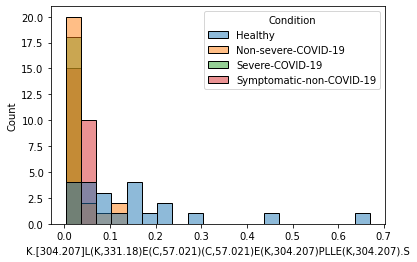

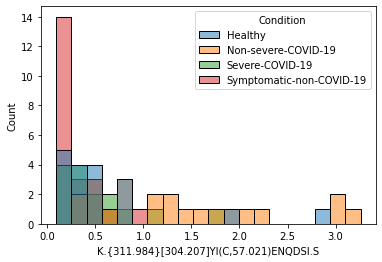

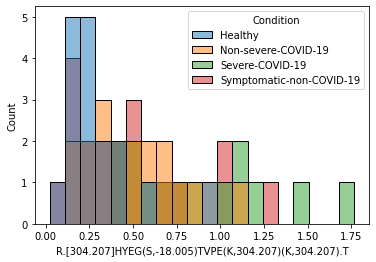

In [12]:
# histogram of the common features
for col in X_drop_common.columns:
  plt.figure()
  sns.histplot(X_drop, x = col, hue = 'Condition', binwidth = (X_drop[col].max()-X_drop[col].min())/20)

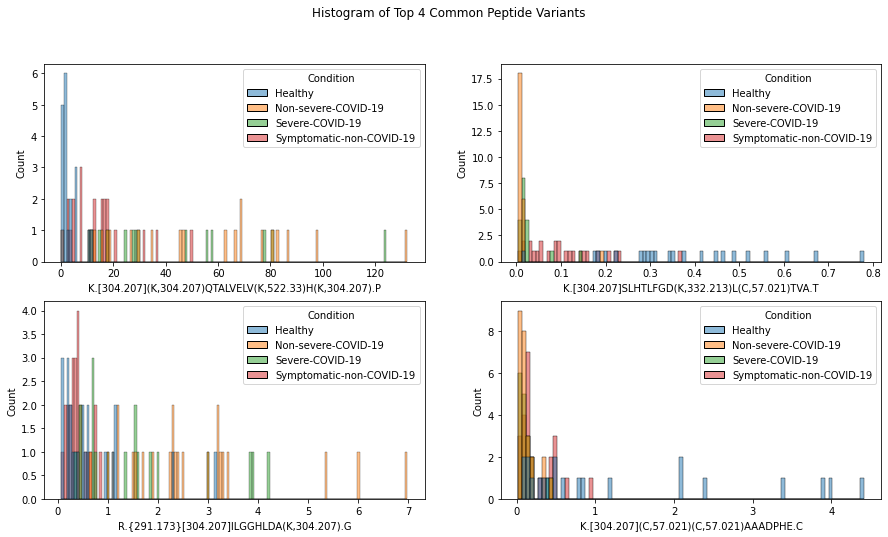

In [16]:
fig, axes = plt.subplots(2,2, figsize = (15,8))
fig.suptitle('Histogram of Top 4 Common Peptide Variants')
sns.histplot(X_drop, x = "K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P", hue='Condition', binwidth = 1, ax = axes[0,0])
sns.histplot(X_drop, x = "K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T", hue='Condition', binwidth = 0.008, ax = axes[0,1])
sns.histplot(X_drop, x = "R.{291.173}[304.207]ILGGHLDA(K,304.207).G", hue='Condition', binwidth = 0.05, ax = axes[1,0])
sns.histplot(X_drop, x = "K.[304.207](C,57.021)(C,57.021)AAADPHE.C", hue='Condition', binwidth = 0.05, ax = axes[1,1])

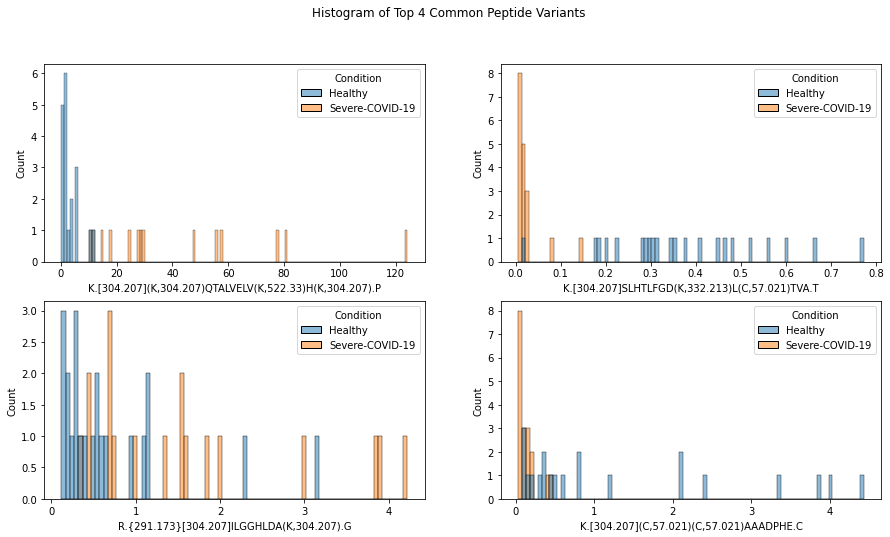

In [17]:
healthy_severe = X_drop
healthy_severe = healthy_severe[healthy_severe["Patient"].str.contains("Symptomatic-non-COVID|Non-severe") == False]
fig, axes = plt.subplots(2,2, figsize = (15,8))
fig.suptitle('Histogram of Top 4 Common Peptide Variants')
sns.histplot(healthy_severe, x = "K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P", hue='Condition', binwidth = 1, ax = axes[0,0])
sns.histplot(healthy_severe, x = "K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T", hue='Condition', binwidth = 0.008, ax = axes[0,1])
sns.histplot(healthy_severe, x = "R.{291.173}[304.207]ILGGHLDA(K,304.207).G", hue='Condition', binwidth = 0.05, ax = axes[1,0])
sns.histplot(healthy_severe, x = "K.[304.207](C,57.021)(C,57.021)AAADPHE.C", hue='Condition', binwidth = 0.05, ax = axes[1,1])

In [20]:
severe_intensities = X_drop["K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P"][X_drop.Condition == "Severe-COVID-19"].dropna()
healthy_intensities = X_drop["K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P"][X_drop.Condition == "Healthy"].dropna()
print("Feature 1: K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P")
print("\t T-test:", stats.ttest_ind(severe_intensities, healthy_intensities, equal_var = False))
print("\t Mann-Whitney rank test:", stats.mannwhitneyu(severe_intensities, healthy_intensities, alternative = 'two-sided'))

severe_intensities = X_drop["K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T"][X_drop.Condition == "Severe-COVID-19"].dropna()
healthy_intensities = X_drop["K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T"][X_drop.Condition == "Healthy"].dropna()
print("Feature 2: K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T")
print("\t T-test:", stats.ttest_ind(severe_intensities, healthy_intensities, equal_var = False))
print("\t Mann-Whitney rank test:", stats.mannwhitneyu(severe_intensities, healthy_intensities, alternative = 'two-sided'))

severe_intensities = X_drop["R.{291.173}[304.207]ILGGHLDA(K,304.207).G"][X_drop.Condition == "Severe-COVID-19"].dropna()
healthy_intensities = X_drop["R.{291.173}[304.207]ILGGHLDA(K,304.207).G"][X_drop.Condition == "Healthy"].dropna()
print("Feature 3: R.{291.173}[304.207]ILGGHLDA(K,304.207).G")
print("\t T-test:", stats.ttest_ind(severe_intensities, healthy_intensities, equal_var = False))
print("\t Mann-Whitney rank test:", stats.mannwhitneyu(severe_intensities, healthy_intensities, alternative = 'two-sided'))

severe_intensities = X_drop["K.[304.207](C,57.021)(C,57.021)AAADPHE.C"][X_drop.Condition == "Severe-COVID-19"].dropna()
healthy_intensities = X_drop["K.[304.207](C,57.021)(C,57.021)AAADPHE.C"][X_drop.Condition == "Healthy"].dropna()
print("Feature 4: K.[304.207](C,57.021)(C,57.021)AAADPHE.C")
print("\t T-test:", stats.ttest_ind(severe_intensities, healthy_intensities, equal_var = False))
print("\t Mann-Whitney rank test:", stats.mannwhitneyu(severe_intensities, healthy_intensities, alternative = 'two-sided'))

Feature 1: K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P
	 T-test: Ttest_indResult(statistic=4.562403611038421, pvalue=0.0005124944846032545)
	 Mann-Whitney rank test: MannwhitneyuResult(statistic=264.0, pvalue=1.9984542662277883e-06)
Feature 2: K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T
	 T-test: Ttest_indResult(statistic=-9.045829326782982, pvalue=5.322147650461292e-09)
	 Mann-Whitney rank test: MannwhitneyuResult(statistic=8.0, pvalue=2.579765331719557e-07)
Feature 3: R.{291.173}[304.207]ILGGHLDA(K,304.207).G
	 T-test: Ttest_indResult(statistic=2.8914145389290224, pvalue=0.007563485656697404)
	 Mann-Whitney rank test: MannwhitneyuResult(statistic=319.0, pvalue=0.0010530471619083148)
Feature 4: K.[304.207](C,57.021)(C,57.021)AAADPHE.C
	 T-test: Ttest_indResult(statistic=-3.8197122346164423, pvalue=0.0010483544367633467)
	 Mann-Whitney rank test: MannwhitneyuResult(statistic=42.0, pvalue=3.672549914771674e-05)


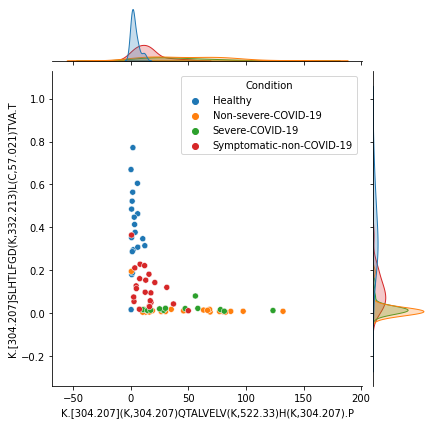

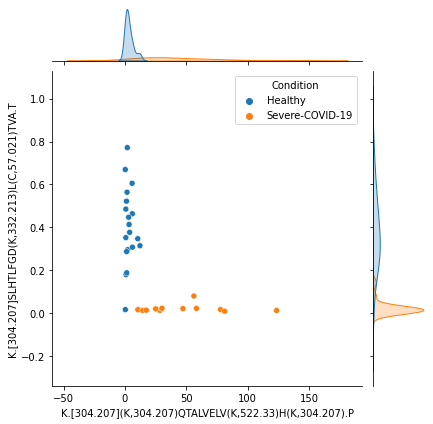

In [21]:
# TOP 2 PEPTIDES
sns.jointplot(x=X_drop["K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P"],
              y=X_drop["K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T"],
              hue=X_drop['Condition'])

sns.jointplot(x=healthy_severe["K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P"],
              y=healthy_severe["K.[304.207]SLHTLFGD(K,332.213)L(C,57.021)TVA.T"],
              hue=healthy_severe['Condition'])

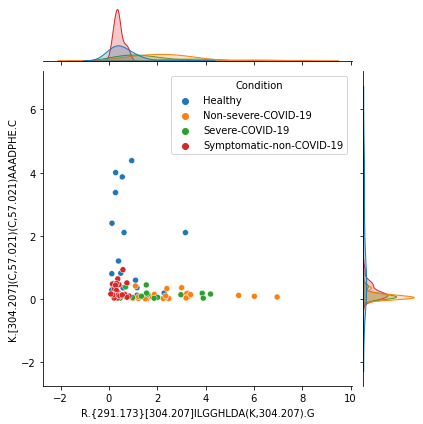

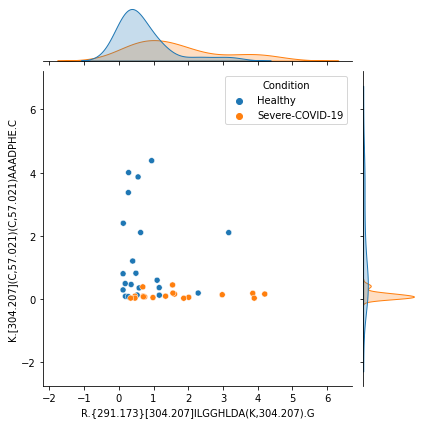

In [22]:
# TOP 3-4 PEPTIDES
sns.jointplot(x=X_drop["R.{291.173}[304.207]ILGGHLDA(K,304.207).G"],
              y=X_drop["K.[304.207](C,57.021)(C,57.021)AAADPHE.C"],
              hue=X_drop['Condition'])

sns.jointplot(x=healthy_severe["R.{291.173}[304.207]ILGGHLDA(K,304.207).G"],
              y=healthy_severe["K.[304.207](C,57.021)(C,57.021)AAADPHE.C"],
              hue=healthy_severe['Condition'])

## Assessment on protein identification

### Show the relation between the peptides in the peptide identification assessment step and their associated proteins (e.g. by a bipartite graph or a peptide-protein table)

In [31]:
# select relevant rows in peptide information
# we use all features identified in both methods but can change that
# could use common features but then the bipartite map would be very simple
selected_peptides = peptide_info[peptide_info['Peptide'].isin(common_features)]
top_proteins = selected_peptides[['Peptide','Top_canonical_protein']].copy()

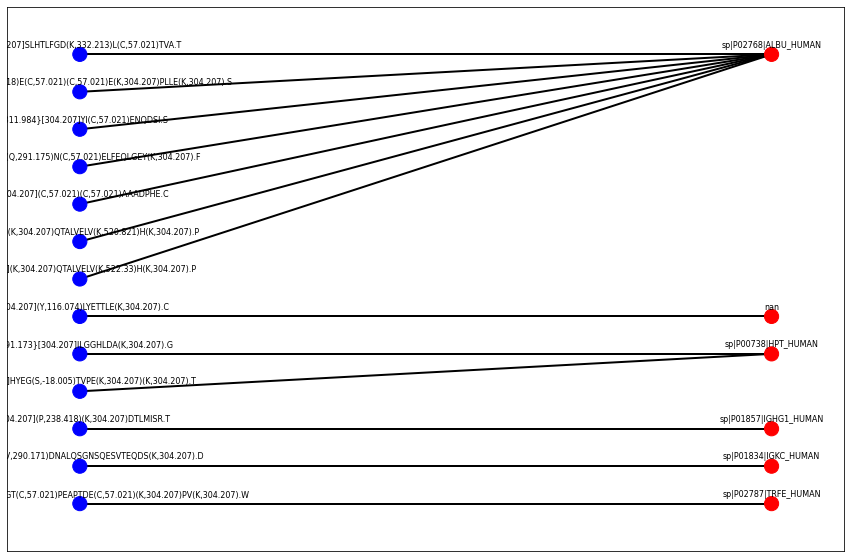

True


In [32]:
# create bipartite graph to show top proteins
import networkx as nx
from networkx.algorithms import bipartite

G = nx.Graph()
G.add_nodes_from(top_proteins['Peptide'], bipartite = 0)
G.add_nodes_from(top_proteins['Top_canonical_protein'], bipartite = 1)
G.add_edges_from((row['Peptide'],row['Top_canonical_protein']) for idx, row in top_proteins.iterrows())
color_dict = {0:'b',1:'r'}
color_list = [color_dict[i[1]] for i in G.nodes.data('bipartite')]
pos = {node:[0, i] for i,node in enumerate(top_proteins['Peptide'])}
pos.update({node:[1, i] for i,node in enumerate(top_proteins['Top_canonical_protein'])})
plt.figure(figsize=(15,10))
nx.draw_networkx(G, pos, with_labels=False, node_color=color_list, node_size = 200, width = 2)
for p in pos:  # raise text positions
    pos[p][1] += 0.25
nx.draw_networkx_labels(G, pos, font_size = 8)
plt.show()
print(nx.is_bipartite(G))

### Give evidence to confirm the protein identification (e.g. whether the peptides are uniquely mapped to the proteins, whether other peptides of the same proteins are also identified)

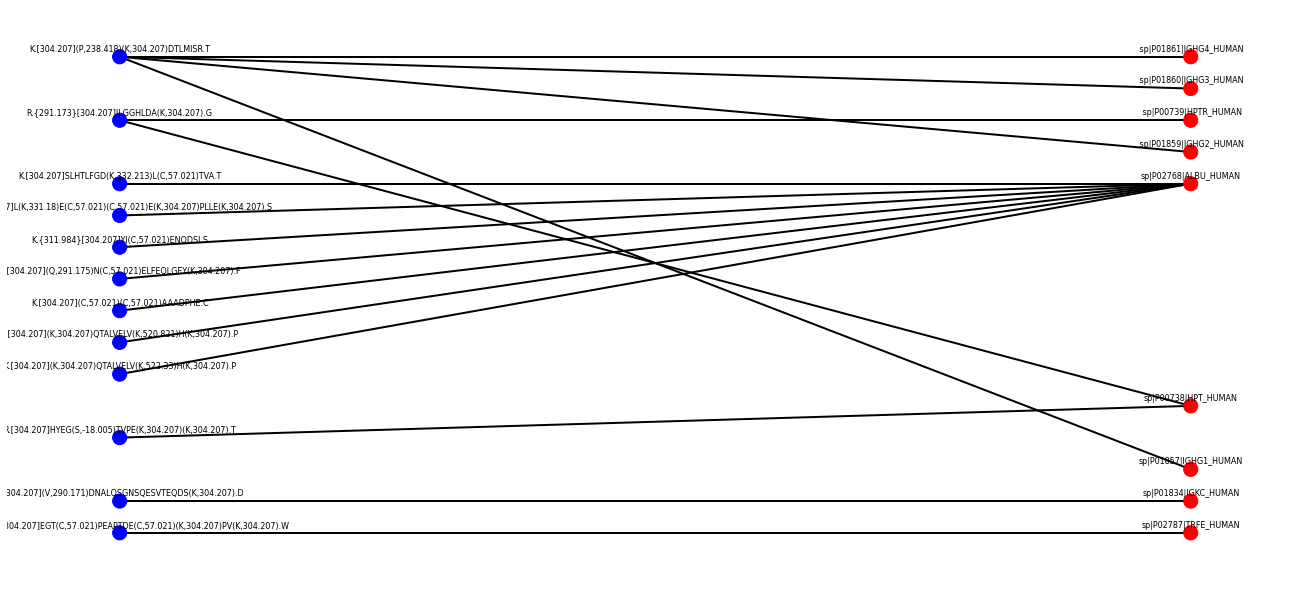

True


In [33]:
# create bipartite graph to show all proteins
proteins = selected_peptides[['Peptide','Canonical_proteins']].copy()
proteins[['protein_1','protein_2','protein_3','protein_4']] =proteins['Canonical_proteins'].str.split(';',expand=True)
proteins = proteins.drop('Canonical_proteins', axis = 1)
proteins = pd.melt(proteins, id_vars = 'Peptide')
proteins = proteins.dropna()

G = nx.Graph()
G.add_nodes_from(proteins['Peptide'], bipartite = 0)
G.add_nodes_from(proteins['value'], bipartite = 1)
G.add_edges_from((row['Peptide'],row['value']) for idx, row in proteins.iterrows())
color_dict = {0:'b',1:'r'}
color_list = [color_dict[i[1]] for i in G.nodes.data('bipartite')]
pos = {node:[0, i] for i,node in enumerate(proteins['Peptide'])}
pos.update({node:[1, i] for i,node in enumerate(proteins['value'])})
plt.figure(figsize=(18,8))
nx.draw(G, pos, with_labels=False, node_color=color_list, node_size = 200, width = 2)
for p in pos:  # raise text positions
    pos[p][1] += 0.25
nx.draw_networkx_labels(G, pos, font_size = 8)
plt.show()
print(nx.is_bipartite(G))

## Assessment on protein-level differential abundance

In [26]:
from scipy import stats

In [27]:
# for protein differential abundance, only check peptides that uniquely map to the protein
protein_da = list(peptide_info[peptide_info['Peptide'].isin(common_features)]['Top_canonical_protein'])
protein_da = peptide_info[peptide_info['Top_canonical_protein'].isin(protein_da)]
protein_da = protein_da.loc[protein_da['Peptide'].isin(list(x.columns))]
protein_da = protein_da.loc[protein_da['Top_canonical_protein'] == protein_da['Canonical_proteins']]
display(protein_da)

,Peptide,Unmodified_sequence,Charge,Top_canonical_protein,Canonical_proteins
29,"K.{42.995}[304.207]DLLFRDDTV(C,57.021)LA(K,304...",.DLLFRDDTVCLAK.,3,sp|P02787|TRFE_HUMAN,sp|P02787|TRFE_HUMAN
57,"D.[215.050]LLFRDDTV(C,57.021)LA(K,304.207).L",.LLFRDDTVCLAK.,3,sp|P02787|TRFE_HUMAN,sp|P02787|TRFE_HUMAN
58,"K.[304.207]DLLFRDDTV(C,57.021)L(A,228.115).K",.DLLFRDDTVCLA.,3,sp|P02787|TRFE_HUMAN,sp|P02787|TRFE_HUMAN
98,"R.[304.207](D,-2.01)DTV(C,57.021)LA(K,304.207).L",.DDTVCLAK.,3,sp|P02787|TRFE_HUMAN,sp|P02787|TRFE_HUMAN
109,"K.[304.207]DLLFRDDTV(C,57.021)LA(K,563.262)LHDR.N",.DLLFRDDTVCLAKLHDR.,3,sp|P02787|TRFE_HUMAN,sp|P02787|TRFE_HUMAN
...,...,...,...,...,...
76479,R.{200.100}[304.207]RHPYFYAPELLF.F,.RHPYFYAPELLF.,4,sp|P02768|ALBU_HUMAN,sp|P02768|ALBU_HUMAN
76483,R.[304.207]RHPYFYAPELLFF.A,.RHPYFYAPELLFF.,4,sp|P02768|ALBU_HUMAN,sp|P02768|ALBU_HUMAN
76486,"R.[304.207]RHPYFYAPELL(F,-13.144)F.A",.RHPYFYAPELLFF.,4,sp|P02768|ALBU_HUMAN,sp|P02768|ALBU_HUMAN
76516,"R.[304.207]YLYEIAR(R,118.093)HPYFYAPELLFFA(K,3...",.YLYEIARRHPYFYAPELLFFAKR.,3,sp|P02768|ALBU_HUMAN,sp|P02768|ALBU_HUMAN


In [34]:
# similar process to getting machine learning data but for protein level differential abundance
peptides_processed = variants[['Unmodified_sequence']+[c for c in variants.columns if 'intensity_for_unmodified_sequence' in c]]
peptides_processed.replace(0.0, np.nan, inplace=True)
peptides_processed = peptides_processed.set_index('Unmodified_sequence')
peptides_processed = peptides_processed.T
peptides_processed.index = peptides_processed.index.map(lambda x: '.'.join(x.split('.')[:2]))
peptides_processed['Condition'] = peptides_processed.index.map(lambda x: x.split('.')[0].split('#')[1])
peptides_processed = peptides_processed[(peptides_processed.Condition == "Healthy") | (peptides_processed.Condition == "Non-severe-COVID-19")| (peptides_processed.Condition == "Severe-COVID-19") 
| (peptides_processed.Condition == "Symptomatic-non-COVID-19")]
peptides_processed = peptides_processed.loc[:,~peptides_processed.columns.duplicated()]
peptides_processed

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Unmodified_sequence,.GARLIPEMDQIFTEVEMTTLEK.,.FTEVEMTTLEK.,.LYQPEYQEVSTEEQR.,.AANSLEAFIFETQDK.,.YSHDFNFH.,.PSVCREAGPQAHMQQVTSSLK.,.QGSTGEEFHFQTGGR.,.HGTDDGVVWMNWK.,.SGNFCLFR.,.DLLFRDDTVCLAKLHDR.,...,.NTYEKYLGEEYVK.,.YEKYLGEEYVK.,.YLGEEYVKAVGNLRK.,.EKYLGEEYVK.,.YLGEEYVKAVGNLRKC.,.YLGEEYVKAVGNL.,.KYLGEEYVK.,.YLGEEYVKAVGN.,.YLGEEYVKA.,Condition
_dyn_#Healthy.HC1,NaN,NaN,0.935916,NaN,NaN,NaN,NaN,0.263552,NaN,0.622236,...,0.226349,1.333834,0.400842,0.465494,0.337217,NaN,NaN,NaN,1.286487,Healthy
_dyn_#Healthy.HC10,6.645649,NaN,NaN,NaN,NaN,NaN,NaN,0.023747,NaN,0.352701,...,NaN,NaN,0.838857,0.223471,0.659497,NaN,NaN,0.429718,NaN,Healthy
_dyn_#Healthy.HC12,3.391896,NaN,NaN,NaN,NaN,NaN,NaN,0.008242,NaN,0.081673,...,NaN,NaN,0.290986,0.085568,0.194509,NaN,NaN,0.154485,NaN,Healthy
_dyn_#Healthy.HC13,1.919552,NaN,NaN,NaN,NaN,NaN,NaN,0.025929,NaN,0.100501,...,NaN,NaN,0.262988,0.083533,0.153772,NaN,NaN,0.193139,NaN,Healthy
_dyn_#Healthy.HC17,NaN,NaN,0.286530,1.259306,NaN,NaN,NaN,NaN,NaN,0.215716,...,0.924962,NaN,0.179170,NaN,0.490916,0.445014,1.085342,0.963943,NaN,Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_dyn_#Symptomatic-non-COVID-19.JBDZ6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073159,NaN,0.049143,...,0.064801,0.024524,0.060716,0.053134,0.005909,NaN,NaN,NaN,NaN,Symptomatic-non-COVID-19
_dyn_#Symptomatic-non-COVID-19.JBDZ7,NaN,0.435434,0.200232,NaN,NaN,NaN,NaN,0.056343,1.672977,0.040711,...,NaN,NaN,0.114214,NaN,0.107188,NaN,NaN,NaN,NaN,Symptomatic-non-COVID-19
_dyn_#Symptomatic-non-COVID-19.JBDZ8,NaN,0.736280,0.170478,NaN,NaN,NaN,NaN,0.068306,1.672654,0.054559,...,NaN,NaN,0.167121,NaN,0.116299,NaN,NaN,NaN,NaN,Symptomatic-non-COVID-19
_dyn_#Symptomatic-non-COVID-19.JBDZ9,NaN,0.796550,0.197400,NaN,NaN,NaN,NaN,0.049022,1.613534,0.045765,...,NaN,NaN,0.152208,NaN,0.104222,NaN,NaN,NaN,NaN,Symptomatic-non-COVID-19


In [35]:
def protein_diff_abun(protein):
  protein_1_da = protein_da.loc[protein_da['Top_canonical_protein']==protein]
  protein_1_pep = list(set(protein_1_da['Unmodified_sequence']))
  pp_p1 = peptides_processed[peptides_processed.columns[peptides_processed.columns.isin(protein_1_pep)]]
  # perform a wilcoxon test (nonparametric)
  # how many features to evaluate and how to hold all values
  mwtest_pro1_all = np.zeros((len(protein_1_pep),len(cond),len(cond)))
  # final values
  mwtest_pro1_final = {}
  for i in range(0,len(protein_1_pep)):
    curr_pep = protein_1_pep[i]
    for j in range(0,len(cond)):
      for k in range(0,len(cond)):
        j_inten = pp_p1[curr_pep][peptides_processed.Condition == cond[j]].dropna()
        k_inten = pp_p1[curr_pep][peptides_processed.Condition == cond[k]].dropna() 
        mwtest_pro1_all[i,j,k] = stats.mannwhitneyu(j_inten,k_inten,alternative = 'two-sided').pvalue
    for arr in np.argwhere(mwtest_pro1_all[i] < 0.05):
      if (np.array2string(arr) in mwtest_pro1_final):
        mwtest_pro1_final[np.array2string(arr)] += 1
      else:
        mwtest_pro1_final[np.array2string(arr)] = 1
  print('----'+protein+'----')
  print('Total Peptides Mapped Uniquely:',len(protein_1_pep))
  for key,value in mwtest_pro1_final.items():
    print(key,'->',value)
  plt.figure()
  cmap = sns.color_palette("icefire", as_cmap=True)
  sns.heatmap(z_score(pp_p1,3).T, cmap=cmap)
  plt.show()

----sp|P02768|ALBU_HUMAN----
Total Peptides Mapped Uniquely: 149
[0 2] -> 30
[2 0] -> 30
[0 1] -> 17
[1 0] -> 17
[1 2] -> 8
[1 3] -> 14
[2 1] -> 8
[3 1] -> 14
[0 3] -> 19
[3 0] -> 19
[2 3] -> 6
[3 2] -> 6


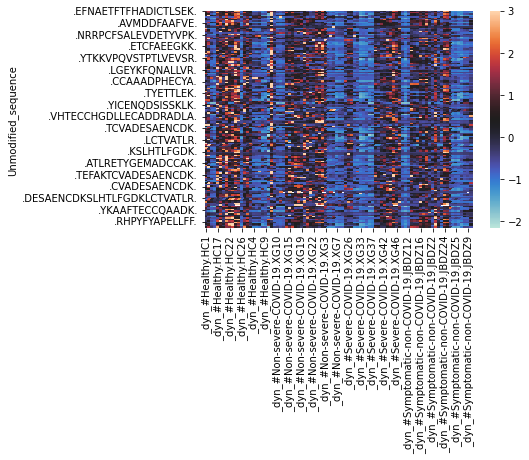

----sp|P00738|HPT_HUMAN----
Total Peptides Mapped Uniquely: 49
[0 2] -> 39
[2 0] -> 39
[1 2] -> 4
[2 1] -> 4
[2 3] -> 23
[3 2] -> 23
[0 1] -> 28
[1 0] -> 28
[0 3] -> 4
[3 0] -> 4
[1 3] -> 1
[3 1] -> 1


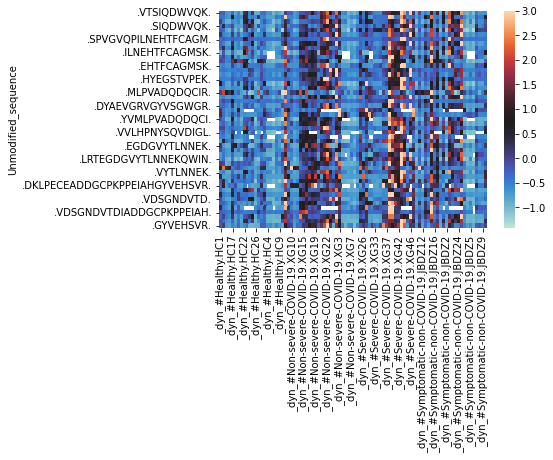

In [36]:
# check for protein level differential abundance of sp|P02768|ALBU_HUMAN
protein_diff_abun('sp|P02768|ALBU_HUMAN')
protein_diff_abun('sp|P00738|HPT_HUMAN')

## Assessment on peptide/variant-level differential abundance

In [37]:
top_peptides = ['.KQTALVELVKHK.','.SLHTLFGDKLCTVA.','.ILGGHLDAK.','.CCAAADPHE.','.EGTCPEAPTDECKPVK.','.VDNALQSGNSQESVTEQDSK.','.YLYETTLEK.','.PKDTLMISR.','.QNCELFEQLGEYK.','.LKECCEKPLLEK.']
peptide_da = peptide_info[peptide_info['Unmodified_sequence'].isin(top_peptides)]
X_drop = X_drop.set_index('Patient')

In [38]:
def peptide_diff_abun(peptide):
  peptide_hm = peptides_processed[peptide]
  peptide_1_da = peptide_da.loc[peptide_da['Unmodified_sequence']==peptide]
  peptide_1_var = list(set(peptide_1_da['Peptide']))
  pp_p1 = X_drop[X_drop.columns[X_drop.columns.isin(peptide_1_var)]]
  # perform a wilcoxon test (nonparametric)
  # how many features to evaluate and how to hold all values
  mwtest_pep1_all = np.zeros((len(pp_p1.columns),len(cond),len(cond)))
  # final values
  mwtest_pep1_final = {}
  #count how many valid peptide variants
  count = 0
  for i in list(pp_p1.columns):
    for j in range(0,len(cond)):
      for k in range(0,len(cond)):
        j_inten = pp_p1[i][X_drop.Condition == cond[j]].dropna()
        k_inten = pp_p1[i][X_drop.Condition == cond[k]].dropna() 
        mwtest_pep1_all[count,j,k] = stats.mannwhitneyu(j_inten,k_inten,alternative = 'two-sided').pvalue
    for arr in np.argwhere(mwtest_pep1_all[count] < 0.05):
      if (np.array2string(arr) in mwtest_pep1_final):
        mwtest_pep1_final[np.array2string(arr)] += 1
      else:
        mwtest_pep1_final[np.array2string(arr)] = 1
    count = count + 1
  print('----'+peptide+'----')
  print('Total Variants:',count)
  for key,value in mwtest_pep1_final.items():
    print(key,'->',value)
  cmap = sns.color_palette("icefire", as_cmap=True)
  plt.figure()
  sns.heatmap(peptide_hm.to_frame(), cmap=cmap)
  plt.show()
  plt.figure()
  sns.heatmap(z_score(pp_p1,3).T, cmap=cmap)
  plt.show()

----.KQTALVELVKHK.----
Total Variants: 5
[0 3] -> 3
[1 3] -> 2
[2 3] -> 2
[3 0] -> 3
[3 1] -> 2
[3 2] -> 2
[0 1] -> 2
[0 2] -> 2
[1 0] -> 2
[2 0] -> 2


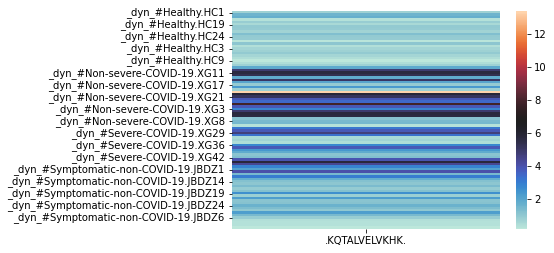

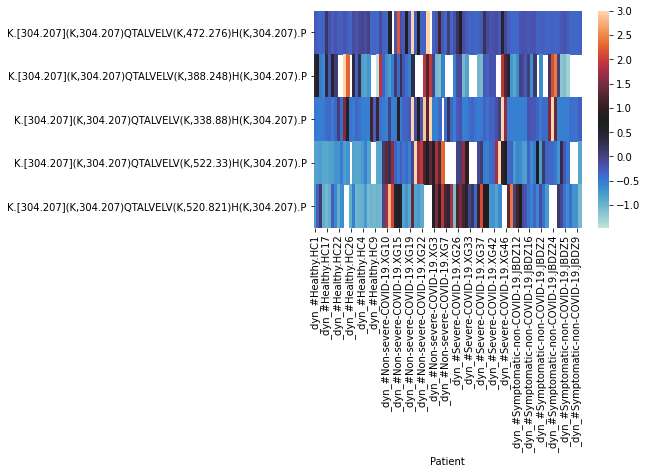

----.SLHTLFGDKLCTVA.----
Total Variants: 5
[0 1] -> 3
[0 2] -> 3
[0 3] -> 3
[1 0] -> 3
[2 0] -> 3
[3 0] -> 3
[1 2] -> 1
[1 3] -> 2
[2 1] -> 1
[2 3] -> 2
[3 1] -> 2
[3 2] -> 2


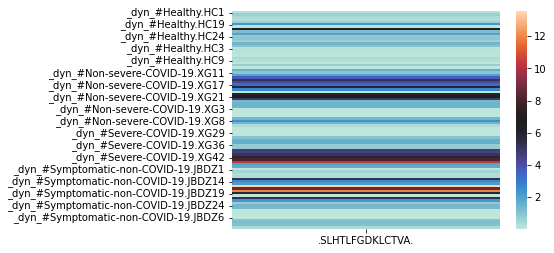

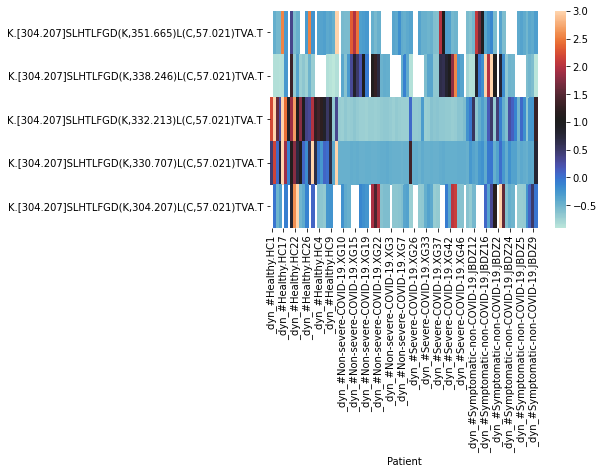

----.ILGGHLDAK.----
Total Variants: 14
[0 2] -> 10
[1 2] -> 7
[2 0] -> 10
[2 1] -> 7
[2 3] -> 7
[3 2] -> 7
[0 1] -> 3
[1 0] -> 3
[1 3] -> 3
[3 1] -> 3


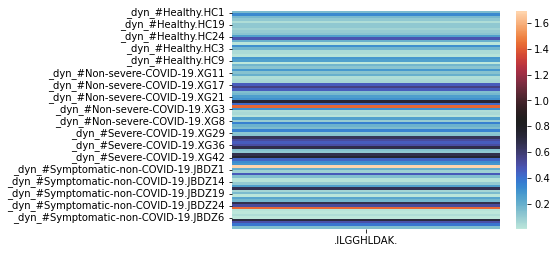

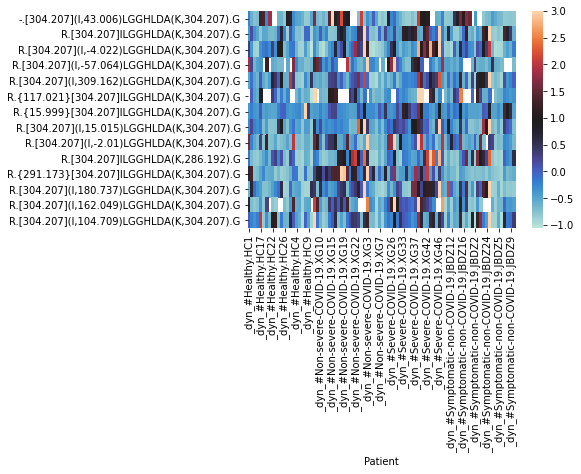

----.CCAAADPHE.----
Total Variants: 3
[0 1] -> 1
[0 2] -> 1
[0 3] -> 1
[1 0] -> 1
[1 3] -> 1
[2 0] -> 1
[2 3] -> 1
[3 0] -> 1
[3 1] -> 1
[3 2] -> 1


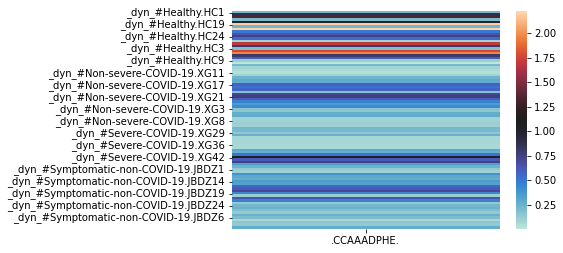

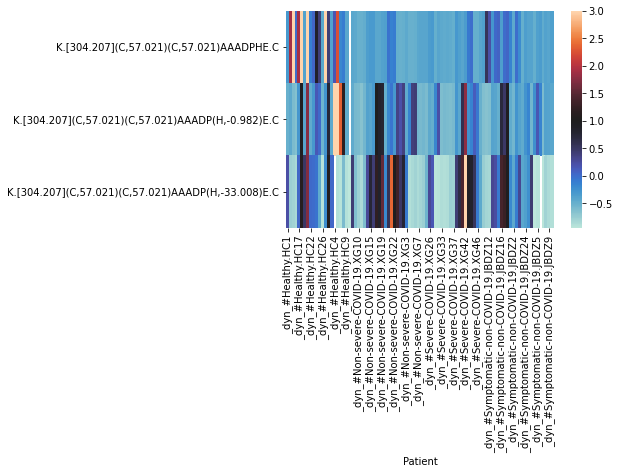

----.EGTCPEAPTDECKPVK.----
Total Variants: 26
[0 1] -> 1
[1 0] -> 1
[1 2] -> 1
[1 3] -> 2
[2 1] -> 1
[3 1] -> 2
[0 2] -> 1
[2 0] -> 1


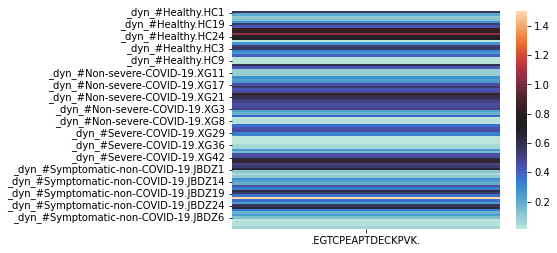

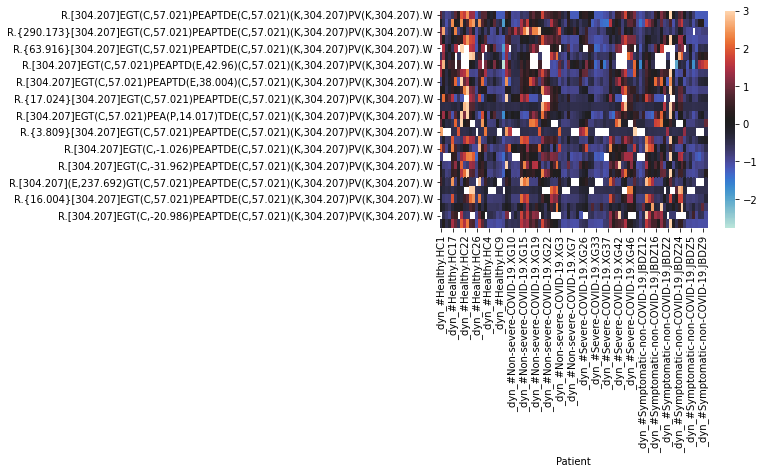

----.VDNALQSGNSQESVTEQDSK.----
Total Variants: 93
[0 1] -> 1
[1 0] -> 1
[1 2] -> 1
[1 3] -> 1
[2 1] -> 1
[2 3] -> 1
[3 1] -> 1
[3 2] -> 1
[0 2] -> 1
[2 0] -> 1


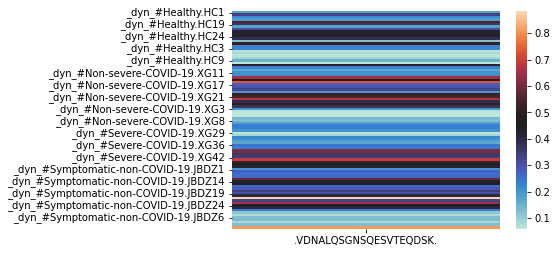

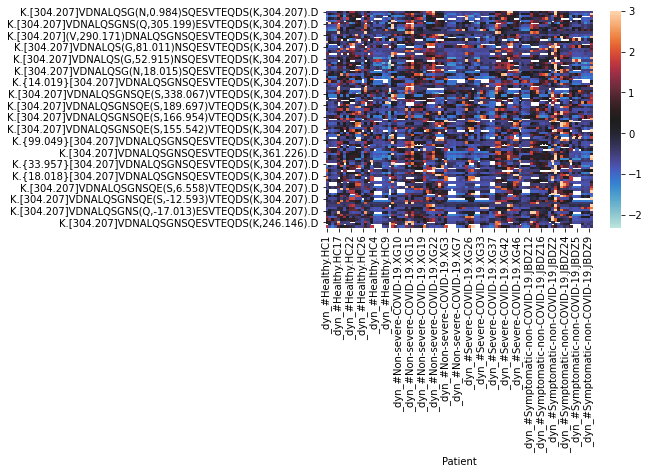

----.YLYETTLEK.----
Total Variants: 2
[0 2] -> 1
[0 3] -> 1
[2 0] -> 1
[3 0] -> 1
[0 1] -> 1
[1 0] -> 1
[1 2] -> 1
[1 3] -> 1
[2 1] -> 1
[2 3] -> 1
[3 1] -> 1
[3 2] -> 1


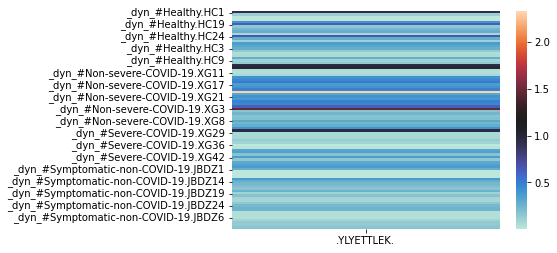

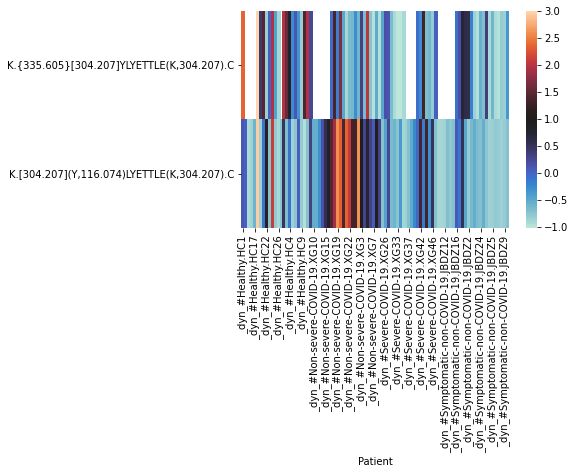

----.PKDTLMISR.----
Total Variants: 5
[0 1] -> 1
[1 0] -> 1
[1 2] -> 1
[1 3] -> 1
[2 1] -> 1
[2 3] -> 1
[3 1] -> 1
[3 2] -> 1


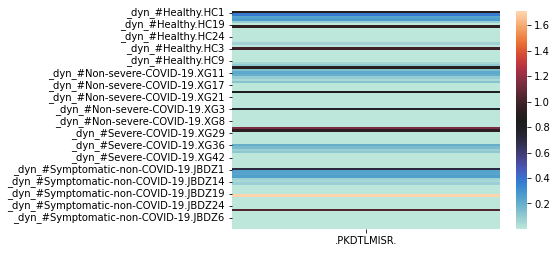

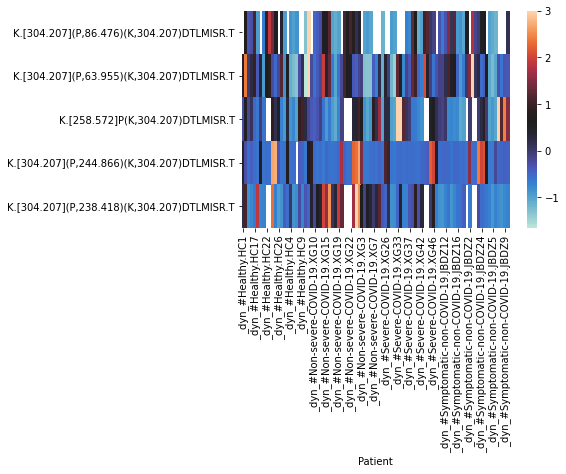

----.QNCELFEQLGEYK.----
Total Variants: 171
[0 1] -> 12
[0 2] -> 23
[0 3] -> 7
[1 0] -> 12
[2 0] -> 23
[3 0] -> 7
[1 3] -> 5
[3 1] -> 5
[1 2] -> 2
[2 1] -> 2
[2 3] -> 2
[3 2] -> 2


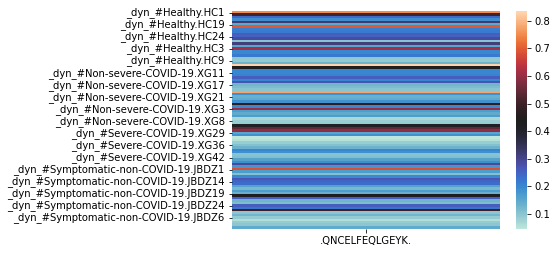

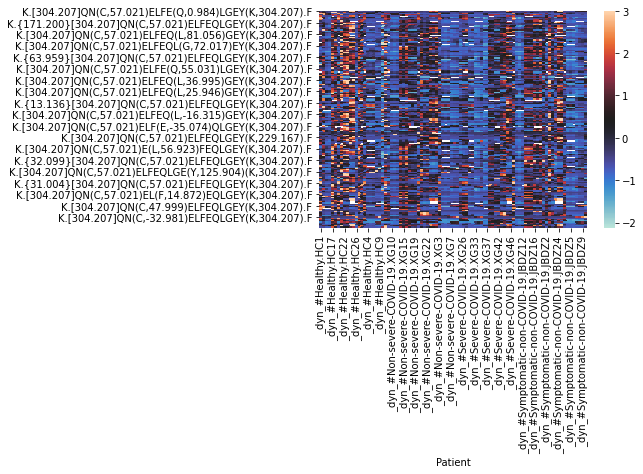

----.LKECCEKPLLEK.----
Total Variants: 20
[0 1] -> 1
[0 2] -> 3
[0 3] -> 3
[1 0] -> 1
[1 2] -> 1
[2 0] -> 3
[2 1] -> 1
[2 3] -> 1
[3 0] -> 3
[3 2] -> 1


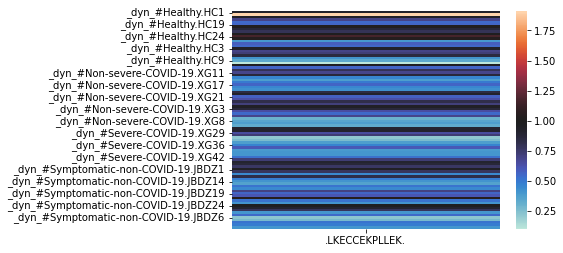

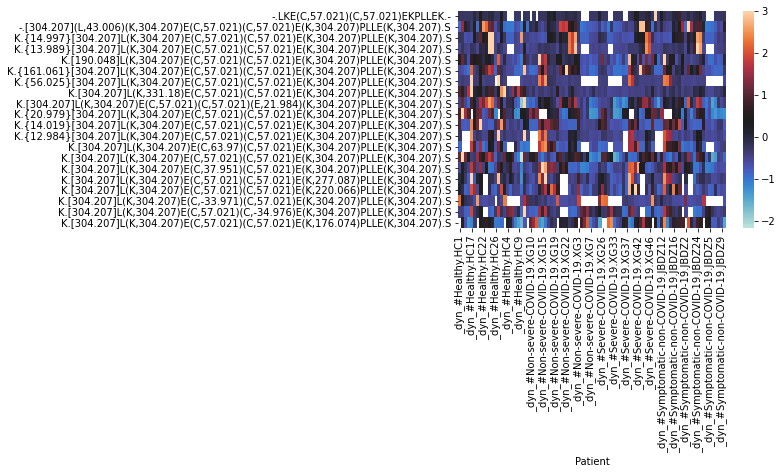

In [39]:
for pep in top_peptides:
  peptide_diff_abun(pep)